In [ ]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
%matplotlib notebook

Input Aperture Radius: 10
Input Inner Annulus Radius: 20
Input Outer Annulus Radius: 40
Input Target Coordinates: 280 242
Input Reference Coordinates: 273 325


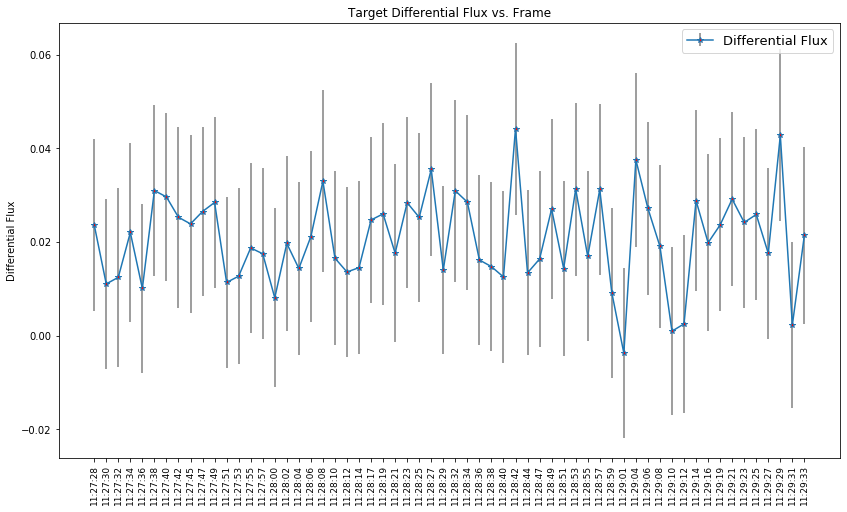

In [5]:
def Graphing(FrameTime,DiffFlux,DiffSigma):
    plt.figure(figsize=(14,8)) 
    plt.rc('xtick',labelsize=9)
    plt.errorbar(FrameTime,DiffFlux,yerr=DiffSigma,mfc='red',
    label='Differential Flux',fmt='-*',ecolor='grey')
    plt.title ('Target Differential Flux')
    plt.legend(loc='upper right',prop={'size':13})
    plt.ylabel('Differential Flux')
    plt.xticks(rotation=90)
    
    
def Function(DataUncertainty,DataCountsArray,
    FrameTime,CompUncertainty,CompCountsArray):
    SigmaA    = [int(a)/int(b) for a,b in zip(DataUncertainty,DataCountsArray)]
    SigmaB    = [int(a)/int(b) for a,b in zip(CompUncertainty,CompCountsArray)]
    DiffFlux  = [int(a)/int(b) for a,b in zip(DataCountsArray,CompCountsArray)]
    DiffSigma = [(c)*np.sqrt((a)**2+(b)**2) for a,b,c in zip(SigmaA,SigmaB,DiffFlux)]
    Graphing(FrameTime,DiffFlux,DiffSigma)
    
    
def Annulus(mask,thick,target,flat):
    outerannu = np.multiply(flat,mask)
    innerannu = np.multiply(flat,thick)
    aperture  = np.multiply(flat,target)
    outerannu [np.isnan(outerannu)] = 0
    innerannu [np.isnan(innerannu)] = 0
    aperture  [np.isnan(aperture)]  = 0
    annulus = np.subtract(outerannu,innerannu)
    avgflux = np.sum(annulus)/np.count_nonzero(annulus)
    scounts = np.sum(aperture)-(avgflux*np.count_nonzero(aperture))
    sigma   = np.sqrt(scounts+np.sum(aperture)+np.count_nonzero(aperture)*(10**2))
    return scounts,sigma
    
    
def Database(TMask,TAperture,TThickness,
             RMask,RAperture,RThickness,
    FitsFile,FitsDark,FitsFlat,normalized):
    CompArray = []
    DataArray = []
    FrameTime = []
    for reconFiles in range(100,160):
        FitsData,header = fits.getdata(FitsFile+
        f'20201021/20201021_2/00{reconFiles}.fits',header=True)
        dark_subtracted = np.subtract(FitsData,FitsDark)
        flat_subtracted = np.true_divide(dark_subtracted,normalized)
        DataArray.append(Annulus(TMask,TThickness,TAperture,flat_subtracted))
        CompArray.append(Annulus(RMask,RThickness,RAperture,flat_subtracted))
        FrameTime.append(header['DATE-OBS'])
    DataCountsArray = []
    DataUncertainty = []
    for each in DataArray:
        DataCountsArray.append(each[0])
        DataUncertainty.append(each[1])
    CompCountsArray = []
    CompUncertainty = []
    for each in CompArray:
        CompCountsArray.append(each[0])
        CompUncertainty.append(each[1])
    for index,each in enumerate(FrameTime):
        FrameTime[index]=each[11:19]
    Function(DataUncertainty,DataCountsArray,
    FrameTime,CompUncertainty,CompCountsArray)

    
def Main():
    np.seterr(divide='ignore',invalid='ignore')
    FitsFile = '/data/tnorecon/RECON_clean/yakima/'
    FitsDark = fits.getdata(FitsFile + '20201021/20201021_4.dark')
    FitsFlat = fits.getdata(FitsFile + '20201021/20201021_3.flat')
    radius = int(input('Input Aperture Radius: '))
    radiii = int(input('Input Inner Annulus Radius: '))
    scopes = int(input('Input Outer Annulus Radius: '))
    x_axis,y_axis = (int(num) for num in input('Input Target Coordinates: ').split())     #280,242
    x_comp,y_comp = (int(num) for num in input('Input Reference Coordinates: ').split())  #273,325
    if radius < radiii < scopes:
        y_arr,x_arr = np.shape(FitsFlat)
        y_arr,x_arr = np.ogrid[:y_arr,:x_arr]
        normalized  = FitsFlat/(np.median(FitsFlat))
        target_mask         = (x_arr-x_axis)**2 + (y_arr-y_axis)**2 <= scopes**2
        target_aperture     = (x_arr-x_axis)**2 + (y_arr-y_axis)**2 <= radius**2
        target_thickness    = (x_arr-x_axis)**2 + (y_arr-y_axis)**2 <= radiii**2
        reference_mask      = (x_arr-x_comp)**2 + (y_arr-y_comp)**2 <= scopes**2
        reference_aperture  = (x_arr-x_comp)**2 + (y_arr-x_comp)**2 <= radius**2
        reference_thickness = (x_arr-x_comp)**2 + (y_arr-x_comp)**2 <= radiii**2
        Database(target_mask,target_aperture,target_thickness,
        reference_mask,reference_aperture,reference_thickness,
        FitsFile,FitsDark,FitsFlat,normalized)   
    else:
        sys.exit('Please Reinput Valid Values')
        
        
if __name__ == '__main__':
    Main()